## Import Solver and Create Model

In [1]:
%matplotlib notebook
import matplotlib
import gurobipy as gurobi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def generateModel(name, objective, siteResources, activityResources, siteNames, activityNames):
    (actNum, siteNum) = np.shape(objective);
    assert(len(siteResources) == siteNum);
    assert(len(activityResources) == actNum);
    assert(len(siteNames) == siteNum);
    assert(len(activityNames) == actNum);
    
    model = gurobi.Model(name);
        
    #Variable generation and objective with price[activity, site]
    Vars = np.empty((activities,sites), dtype=gurobi.Var)
    for i, ObjectiveByActivity in enumerate(objective):
        for j, obj in enumerate(ObjectiveByActivity):
            Vars[i,j] = model.addVar(vtype=gurobi.GRB.BINARY, obj=-obj, name='({:},{:})'.format(activityNames[i],siteNames[j]));
    model.update()
    
    #Cost Constraints
    for j in range(siteNum):
        model.addConstr(gurobi.quicksum(var*cost for var,cost in zip(Vars[:,j],activityResources)) <= siteResources[j], 'Site: {:}'.format(siteNames[j]))   
        
    #Activity constraints
    for i in range(actNum):
        model.addConstr(gurobi.quicksum(var for var in Vars[i,:]) <= 1, 'activity: {:}'.format(activityNames[i]));
        
    model.update();
    return model, Vars;

### Test problem

In [3]:
sites = 136;
activities = 5000;
resources = 3;

siteNames = ['{:}'.format(i) for i in range(sites)];
activityIds = ['{:}'.format(i) for i in range(activities)];

resourceNames = ['resource{:}'.format(i) for i in range(resources)];

r = np.random.rand(activities);
ind = np.zeros(activities, dtype=int);
#ind[r < 0.2] = 0;
ind[(0.33 <= r) & (r < 0.66)] = 1;
ind[r >= 0.66] = 2;

activityRequirements = np.zeros((activities,resources));
for i,j in enumerate(ind):
    activityRequirements[i,j] = np.random.rand(1);

siteConstraint = 10*np.random.rand(sites,resources);
siteConstraint[:,1] *= 0.5;
siteConstraint[:,1] *= 0.2;
siteConstraint[:,2] *= 0.05;

In [4]:
#Create complimentary resource requirements
#for i in range(resources):
#    activityRequirements[:,i] = 1.0/0.3 * activityRequirements[:,i]*np.array(activityRequirements[:,i]<0.3, dtype=int);
#    for j in range(i):
#        activityRequirements[:,i] = activityRequirements[:,i]*(activityRequirements[:,j]>0);

#Create profit matrix such that profit is zero if activity does not use a particular constraint.
Profit = np.random.rand(activities, sites, resources);
Profit = np.array(Profit>0.6, dtype=int)
for i in range(resources):
    Profit[:,:,i] = Profit[:,:,i]*np.tile(activityRequirements[:,i:i+1]>0, (1,sites));
Cost = np.empty((activities, sites, resources));
for i in range(resources):
    Cost[:,:,i] = np.tile(np.random.rand(activities,1),(1,sites));
Cost = np.array(Cost);

eps = -0.1;
OF = eps*Cost*Profit + Profit;

In [5]:
models = [];
Vars = [];
for i in range(resources):
    m, v = generateModel('test', OF[:,:,i], siteConstraint[:,i], activityRequirements[:,i], siteNames, activityIds);
    m.setParam('TimeLimit', 90);
    models.append(m); Vars.append(v);

Changed value of parameter TimeLimit to 90.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter TimeLimit to 90.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter TimeLimit to 90.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


In [6]:
models[0].optimize()
models[1].optimize()
models[2].optimize()

Optimize a model with 5136 rows, 680000 columns and 901544 nonzeros
Coefficient statistics:
  Matrix range    [5e-05, 1e+00]
  Objective range [9e-01, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [6e-02, 1e+01]
Found heuristic solution: objective -1329.62
Presolve removed 3371 rows and 593917 columns
Presolve time: 1.28s
Presolved: 1765 rows, 86083 columns, 172166 nonzeros
Variable types: 0 continuous, 86083 integer (86083 binary)

Root relaxation: objective -1.429163e+03, 8328 iterations, 1.84 seconds
Total elapsed time = 5.65s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -1429.1632    0  200 -1329.6231 -1429.1632  7.49%     -    6s
H    0     0                    -1384.033052 -1429.1632  3.26%     -    7s
H    0     0                    -1406.398805 -1429.1632  1.62%     -    7s
H    0     0                    -1411.033647 -1429.1632  1.28%     -   14s


### Read In and Solve Uncoupled Problems

## Output Results

In [7]:
#convert solution into matrix
f = np.vectorize(lambda x: x.x);
X = [];
for v in Vars:
    X.append(f(v));

In [11]:
#Calculate cost, profit and risk and print with objective function
cost = [];
profit = [];
risk = [];
for i, x in enumerate(X):
    cost.append(np.sum(Cost[:,:,i]*x, axis=(0,1)))
    profit.append(np.sum(Profit[:,:,i]*x, axis=(0,1)))
    
obj = [];
for model in models:
    obj.append(model.objVal);

print('OF: \t{:}'.format(sum(obj)))
print('Cost: \t-{:}'.format(sum(cost)))
print('Profit: {:}'.format(sum(profit)))
print('Risk: \t{:}'.format('???'))

OF: 	-2169.7803245656573
Cost: 	-1092.1967543434282
Profit: 2279.0
Risk: 	???


In [21]:
#Print utilisation of each resource
siteUse = np.zeros((len(siteNames),len(models)),dtype=np.double);
for r, model in enumerate(models):
    for a, activityName in enumerate(activityIds):
        for s, siteName in enumerate(siteNames):
            var = model.getVarByName('({:},{:})'.format(activityName,siteName));
            siteUse[s,r] += var.x*activityRequirements[a,r]

print('Resource Utilisation')
for name, utilisation in zip(resourceNames,np.divide(sum(siteUse),sum(siteConstraint))):
    print("{:}: {:}".format(name, utilisation));

Resource Utilisation
resource0: 0.9855193957170647
resource1: 0.964581065916673
resource2: 0.9710619897082363


In [20]:
#Activity completion
xtot = np.sum(X,axis=(0,2));
assert(np.all(xtot<=1))
print('activity completion rate: \t{:}'.format(sum(xtot)/activities))

xtot = 0;
atot = 0;
for i in range(resources):
    x = np.sum(X[i], axis=1)
    assert(np.all(x<=1))
    xtot += sum(x)
    #print('resource{:}: {:}'.format(i, sum(x)))
    aR = activityRequirements[:,i:i+1]
    #print('needed{:}: {:}'.format(i, sum(np.array(aR>0, dtype=int))[0]))
    atot += sum(np.array(aR>0, dtype=int))[0]
    print('resource{:}: {:}'.format(i, sum(x)/sum(np.array(aR>0, dtype=int))[0]))
    
print(xtot)
print(atot)
print('activity completion rate: \t{:}'.format(xtot/atot))

activity completion rate: 	0.4558
resource0: 0.9097605893186004
resource1: 0.28879310344827586
resource2: 0.1877504293073841
2279.0
5000
activity completion rate: 	0.4558


## Plot Some Results

<IPython.core.display.Javascript object>


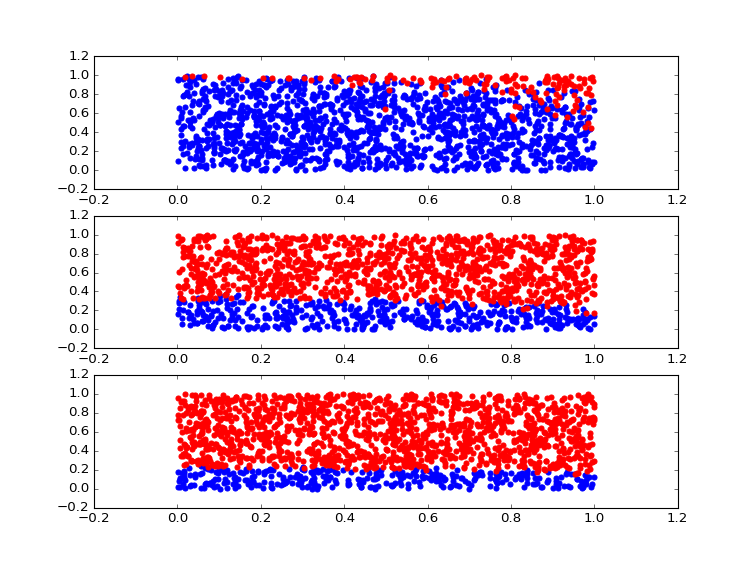

In [16]:
#resource
figs, ax = plt.subplots(resources)
for i in range(resources):
    aR = activityRequirements[:,i:i+1]
    x = np.sum(X[i], axis=1)
    ax[i].scatter(Cost[:,0,i][x==1], aR[x==1], color='b')
    ax[i].scatter(Cost[:,0:1,i][x==0][aR[x==0]>0], aR[x==0][aR[x==0]>0], color='r')

## Epsilon Study

In [ ]:
import pickle

results = [];

for eps in [0.0, -0.1, -0.3, -0.5, -0.7, -1.0, -10.0]:
    OF = eps*Cost*Profit + Profit;
    models = [];
    Vars = [];
    for i in range(resources):
        m, v = generateModel('test', OF[:,:,i], siteConstraint[:,i], activityRequirements[:,i], siteNames, activityIds);
        m.setParam('TimeLimit', 90);
        models.append(m); Vars.append(v);
    models[0].optimize()
    models[1].optimize()
    models[2].optimize()
    
    f = np.vectorize(lambda x: x.x);
    X = [];
    for v in Vars:
        X.append(f(v));

    results.append({'eps':eps, 'X':X})
    
    with open('results.dat','wb') as f:
        pickle.dump([results, Cost, Profit, siteConstraint, activityRequirements, resourceNames, activityIds, siteNames, activities, sites, resources]);
    

Changed value of parameter TimeLimit to 90.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


In [24]:
import pickle

with open('results.dat','rb') as f:
    [results, Cost, Profit, siteConstraint, activityRequirements, resourceNames, activityIds, siteNames, activities, sites, resources] = pickle.load(f);

resource = [];
activity = [];

for r in results:
    #Print utilisation of each resource
    siteUse = np.zeros((len(siteNames),len(models)),dtype=np.double);
    for r, model in enumerate(models):
        for a, activityName in enumerate(activityIds):
            for s, siteName in enumerate(siteNames):
                var = model.getVarByName('({:},{:})'.format(activityName,siteName));
                siteUse[s,r] += var.x*activityRequirements[a,r]

    print('Resource Utilisation')
    ru = np.divide(sum(siteUse),sum(siteConstraint));
    resource.append(ru);

    #Activity completion
    xtot = np.sum(X,axis=(0,2));
    activity.append(sum(xtot)/len(activityRequirements[:,0]));

#resource
figs, ax = plt.subplots(resources+1)
for i in range(resources):
    ax[i].scatter(eps, [x[0] for x in resource]);
ax[-1].scatter(eps, activity);

EOFError: Ran out of input